# FastScape

This is the barebones of the model developed by Prof Jean Braun (jeaun.braun@ujf-grenoble.fr) that was implemented during a short course in early May 2016.

## D8 Routing

This is a routing algorithm.
We will use the following:

Grid of 10x10
Boundary conditions:

## C1
* h = 0
* U = 0
on all boundaries so all at base level. However, this will need some 1m high random noise to perturb things.

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

debug = False
nx,ny = 51, 51
nn = nx*ny
xl, yl = 1000,1000
kf = 0.0001
n = 1
m = 0.4
u = 0.0002
dt = 10000
dx = xl/(nx-1) #change in x
dy = yl/(ny-1) #change in y

We need to add some random noise to each point in the mesh, because otherwise we can not create any receivers.

In [2]:
#np.random.seed(123) #For checking that things are running the same each time.
h = []
for i in range(nn):
    h.append(np.random.random())

print(len(h))

2601


We now need to create the receiver function, so the first thing we need to have is the neighbours. From there, we can calculate the steepest slope of each neighbour, and therefore the receiver function.

(It is possible to convert the 2D grid to a single vector. This is done for a given node `i,j` which will be referenced as `arr[ij]`. The general formula is `ij = i+(j-1)*nx`, which in Python (and other zero-based languages like C) becomes: `ij = i+j*nx` because of indexing.)

First we set up the receiver array to have each value as itself and the length for each node to its steepest neighbour to be zero.

Then we can calculate the values for each point. This is done by stepping through the grid and finding the global reference.

Once the global reference of a given point `ij` is known, we can compute the distance to each neighbour of `ij`, which, in combination with the heights of the point and each of its neighbours, can be used to calculate the slope. The calculation is simply `difference in height/distance`.

This is a deeply nested loop: we want to go over each point in the overall grid (loop 1 and 2). We then look at a point `ij` and each of its eight neighbours and get a global value `ijk` for each neighbour in turn. The heights of `ij` are compared to each `ijk`.

In [3]:
def receiver(h, nn):
    rec_array = [i for i in range(nn)]
    length =  [0 for i in range(nn)]
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            ij = i + j * nx
            max_slope = 0
            for ii in range(-1, 2):
                for jj in range(-1, 2):
                    ii_val = i + ii
                    jj_val = j + jj
                    ijk = ii_val + jj_val * nx
                    if ijk != ij:
                        distance = np.sqrt(((dx**2)*(ii**2))+((dy**2)*(jj**2)))
                        slope = (h[ij] - h[ijk]) / distance
                        if slope > max_slope:
                            max_slope = slope
                            rec_array[ij] = ijk
                            length[ij] = distance
    return (rec_array, length)

## Donors

Now, we need to know how many nodes give to a given node. Essentially, we want to answer the question: "how many nodes have `ij` as a receiver?"

As a matter of convention, a node that is its own receiver (and therefore a local or global base level) will not be listed as a donor of itself, nor increment the donor count.

This is an O(n^2) implementation:
    donors = [[] for i in range(nn)]
    num_donors = [0 for i in range(nn)]

    for i in rec_array:
        for j in rec_array:
            if i != j:
                if rec_array[j] == rec_array[i]:
                    donors[i].append(j)
                    num_donors[i] += 1

This is a better, O(n) implementation. It works by getting each node to increment the count of the node it contains. It can then also add its own value to a list of (initially) empty lists.

In [4]:
def get_donors(rec_array, nn):
    num_donors = [0 for i in range(nn)]
    donors = [[0 for i in range(nn)] for j in range(8)]

    for ij in range(nn):
        if rec_array[ij] != ij:
            k = rec_array[ij]
            donors[num_donors[k]][k] = ij
            num_donors[k] += 1
    return (num_donors, donors)

## The Stack

Now we want to try and identify the nodes that are linked to each other, which we will do recursively.

1. First, we identify the base-level and local minima nodes.
    * This is the case when each node is its own receiver.
2. See its donors and go to each of their donors in turn.

In [5]:
def find_stack(ij, stack, nstack, donors, num_donors, debug):
    '''
    Recursively put the donors of ij on the stack.
    '''
    for k in range(num_donors[ij]):
        if debug:
            print("ij:", ij, "k:", k, "nstack:", nstack)
        ijk = donors[k][ij]
        stack[nstack[0]] = ijk
        nstack[0] = nstack[0] + 1
        if debug:
            print ("Before: ",ij, "\t", k, "\t", nstack, "\n", stack) #Debugging comment
        find_stack(ijk, stack, nstack, donors, num_donors, debug)

def get_stack(rec_array, nn):
    nstack = [0]
    stack = [0 for i in range(nn)]
    for ij in range(nn):
        if rec_array[ij] == ij:
            stack[nstack[0]] = ij
            nstack[0] = nstack[0] + 1
            if debug:
                print("ij:", ij, "nstack:", nstack) #debugging comment
            find_stack(ij, stack, nstack, donors, num_donors, debug)
    return stack

## Area

In order to create the overall area of each catchment, we want to know the area that each node in the catchment receives. This area is the sum of the area of each donor node, so we want to give the area of a given node to its reciever. If this is done for each node, then the area of a given node will be what we want it to be.

Up until now, we have used the stack in normal order, ascending, but randomly spaced. If we reverse the stack, we can start at the highest points and sum all the values that each node gives to its receiver.

In [6]:
def reverse_stack(stack, nn):
    rev_stack = []
    for i in range(nn):
        if debug:
            print(nn-i-1, stack[nn-i-1])
        rev_stack.append(stack[nn-i-1])
    return rev_stack

def get_area(rev_stack, nn, rec_array):
    area = [dx*dy for i in range(nn)]

    for ij in rev_stack:
        if ij != rec_array[ij]:
            area[rec_array[ij]] = area[rec_array[ij]] + area[ij]
    return area

## The mathy bit

### Rate of incision
Starting from flat you concentrate some water, which then starts to cut down. The sides of a small channel becomes a localised slope, leading to failure. Most of the action is on the walls of the valley, but the driver is the stream in the valley base.

Valleys tend to get deeper over time, and downstream. Without uplift with respect to base level, you can not get incision. This uplift is some sort of tectonic process, and is what causes rivers.

Rate of incision is proportional to:
1. Slope
2. Discharge (Volume of Water / unit time)

Rate of incision is as follows:
\begin{equation}
\frac{\delta h}{\delta t} = U-k_{f}A^{m}S^{n}
\end{equation}
where $h =$ height, $t =$ time, $U =$ uplift, $S =$ slope, $A =$ catchment area, $k_f =$ fluvial erosion constant. $K_f = [10^8]$, $m/n = 0.4$ (therefore: $n=1, m=0.4$, and overall equation becomes 
\begin{equation}
\frac{\delta h}{\delta t} = U-k_{f}A^{m=0.4}
\end{equation}
*Catchment* is the area of a landscape that drains through a given point. This is what we calculated above, for each point in the grid.

This can be rewritten as:
\begin{equation}
\frac{\delta h}{\delta t} = U-k_{f}A^{m} \frac{\delta h}{\delta x}
\end{equation}
for a given point x. Tells us how the change in time changes in relation to the change in time. Greater change in $h$ leads to more rapid change in $t$. You need to have an initial condition: $h( t = 0 )$ in order to see how things change without that. This also means that change in height for the entire area does not affect things. The value of the landscape needs to be fixed as well: $(h(x = x_0) = h_0$ as a boundary condition. This fixed height is termed *base level*, which is usually at sea level.

Base level can be changed by either raising the land or lowering the sea.

If we have a mesh with a known height $h$ for each $i$, $j$, we can use the first-order Taylor approximation:
\begin{equation}
f(x) = f(a) + (x-a)\frac{\delta f}{\delta x}(a)
\end{equation}
for a given $i$,$j$.

So, the Taylor approximations for our situation will be the following:
\begin{equation}
h_{i,1j} = h_{ij} + \Delta x \frac{\delta h}{\delta x} ij
\end{equation}
which means that the first order ( $
\frac{\delta h}{\delta x}ij \simeq \frac{h_{i+1j} - h_{ij}}{\Delta x}
$ )
and second order (
$
\frac{\delta^2 h}{\delta x^2}ij \simeq \frac{h_{i+1j} - h_{ij}}{\Delta x^2}
$ ) can be more easily computed.

So, what we will try and solve is an implicit method, using the following:
\begin{equation}
h_f(t + \Delta t) = h_{ij}(t) + U\Delta t - \frac{k_f \Delta t A_{ij}^m}{l_{ij}} \left[h_{ij} + \Delta h_{ij}\right]
\end{equation}

There is also an explicit solution, but this is harder to solve computationally.

## Using the Donor, Receiver and Stack

Given a mesh, with a stack calculated for the entire mesh, we know that a node on the boundary has nothing happening:
$h_1 = 0$. From there, we can move up the stack, using the receiver of a given node as the previous time.

Therefore, in the following:
\begin{equation}
h_f(t + \Delta t) = h_{ij}(t) + U\Delta t - \frac{k_f \Delta t A_{ij}^m}{l_{ij}} \left[h_{ij} + \Delta h_{ij}\right]
\end{equation}
let $F = \frac{k_f \Delta t A_{ij}^m}{l_{ij}}$.
Then
\begin{equation}
h_f(t + \Delta t) = \frac{h_{ij}(t) + U\Delta t + Fh_{ij}}{1 - F}
\end{equation}
This works nicely, because for an arbitrarily small $\Delta t$ we get:
\begin{equation}
\lim_{\Delta t \rightarrow 0} = \frac{h_{ij}(t) + 0 + 0}{1 - 0}
\end{equation}
and for an arbitrarily large $\Delta t$:
\begin{equation}
\lim_{\Delta t \rightarrow \infty} = \frac{h_{ij}(t) + U\Delta t + Fh_{ij}}{1 - F}
\end{equation}

In [7]:
def uplift(nx, ny, h, u, dt):
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            ij = i+j*nx
            h[ij] = h[ij] + u * dt
    return h

In [8]:
def erode(stack, nn, m, kf, dt, length):
    for ij in range(nn):
        ijk = stack[ij]
        if rec_array[ijk] != ijk:
            f = area[ij]**m*kf*dt / length[ijk]
            h[ijk] = ( h[ijk] + f*h[rec_array[ijk]] ) / (1+f)
    return h

## Generating topography

In order to get our topography, we need to iterate through the previous process a number of times. Each time will raise the landscape and erode.

In [9]:
for i in range(100):
    rec_array, length = receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    #print (max(h), min(h), np.mean(h), np.median(h))

### Pretty Artworks!

So, now we want to actually be able to visualise what we have created.
This is easily done using `matplotlib`.

Because we have been using standard Python lists, we need to convert it to a numpy array. This can be easily reshaped back into our original grid using `np.reshape()` with the values of `nx` and `ny`.

We can also do this as a 3D plot, if we desire. This works better outside the notebook for some reason.

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    surf = ax.plot_surface(X,Y,to_plot,cmap='viridis')
    plt.show()

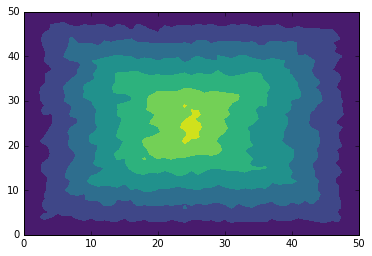

In [10]:
to_plot = np.array(h)
to_plot = np.reshape(h, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

## Cyclic Boundaries

We can treat the grid as infinite in one axis by changing the `reciever()` function to wrap on one axis. We also need to allow the `uplift()` function to include those boundaries.

So, instead of using the range 1 -- `nx-1`, we will use the full range of `nx`. (Note that this can also be done for the y axis, using `ny` instead.)

In [11]:
def cyc_receiver(h, nn):
    rec_array = [i for i in range(nn)]
    length =  [0 for i in range(nn)]
    for i in range(nx):
        for j in range(1, ny-1):
            ij = i + j * nx
            max_slope = 0
            for ii in range(-1, 2):
                for jj in range(-1, 2):
                    ii_val = i + ii
                    jj_val = j + jj
                    if ii_val > nx-1:
                        ii_val = 0
                    elif ii_val < 0:
                        ii_val = nx-1
                    ijk = ii_val + jj_val * nx
                    if ijk != ij:
                        distance = np.sqrt(((dx**2)*(ii**2))+((dy**2)*(jj**2)))
                        slope = (h[ij] - h[ijk]) / distance
                        if slope > max_slope:
                            max_slope = slope
                            rec_array[ij] = ijk
                            length[ij] = distance
    return (rec_array, length)

def cyc_uplift(nx, ny, h, u, dt):
    for i in range(nx):
        for j in range(1, ny-1):
            ij = i+j*nx
            h[ij] += u * dt
    return h

We can then repeat our earlier running and plotting steps, using our new `cyc_receiver()` and `cyc_uplift()` functions.

In [12]:
for i in range(100):
    rec_array, length = cyc_receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = cyc_uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    if i == 50:
        u = 0
    #print (max(h), min(h), np.mean(h), np.median(h))

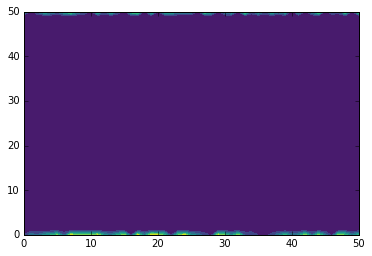

In [13]:
to_plot = np.array(h)
to_plot = np.reshape(h, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

It is is also possible to plot the value of the `area` rather than the value of the `height` at each point.

This gives us an indication of the discharge at a given point.

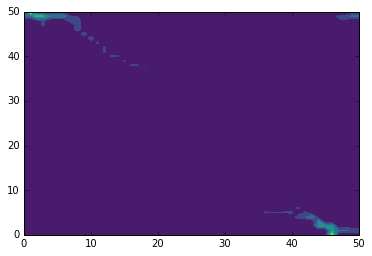

In [14]:
to_plot = np.array(area)
to_plot = np.reshape(area, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

### A Caveat

The resolution that you use will affect the number of rivers. A reliance on the resolution of your model affecting your model is usually a bad thing.

In order to eliminate this, we will allow for diffusion off the slopes.

This uses the well-known diffusion equation:
\begin{equation}
\frac{\delta h}{\delta t} = K_D\frac{\delta^2 h}{\delta x^2}
\end{equation} for $h(x=0) = 0, h(x=l) = 0, h(t=0) = ?$

Explicit $\rightarrow$ Diffusion
$\Delta t << \tau$ (the charactistic time scale)

Characteristic diffusion time scale:
$\tau = \frac{L^2}{K_D} = \frac{{x_l}^2}{K_D}$

So, we want to get this to be dimensionless by dividing each dimensioned variable by a characteristic unit:
$h' = h/H, x' = x/L, t' = t/\tau$

By letting $\tau = \frac{L^2}{K_D}$, we can simplify things to:
\begin{equation}
\frac{h'}{\delta t'} = K_D\frac{\delta^2 h'}{\delta x'^2}
\end{equation}

$\tau$ here is the diffusion time scale, and will indicate the amount of time that it would take to erode a given hill.
For the model we have, $L^2$ is 100km $\times$ 100km ($10^9$), and $\tau$ is:
$\frac{{10^5}^2}{10} << 10^9$

In [15]:
def diffusion():
    #stuff for diffusion:
    hp = []
    hp = [h[ij] for ij in range(nn)]
    
    fact_x = dt*kd/dx**2
    fact_y = dt*kd/dy**2
    
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            ipj = i+j*nx
            imj = -i+j*nx
            ijp = i+(j+1)*nx
            if ijp > ny-1:
                ijp = 0
            elif ijp < 0:
                ijp = ny-1
            ijm = i+(j-1)*nx
            if ijm < 0:
                ijm = ny-1
            h[ij] = h[ij] + fact_x * ( hp[ipj] - 2*hp[ij] + hp[ijm] ) + fact_y * ( hp[ijp] - 2*hp[ij] + hp[ijm] )

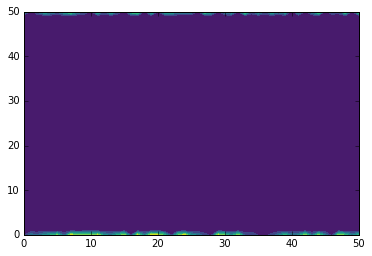

In [16]:
for i in range(100):
    rec_array, length = cyc_receiver(h, nn)
    num_donors, donors = get_donors(rec_array, nn)
    stack = get_stack(rec_array, nn)
    rev_stack = reverse_stack(stack, nn)
    area = get_area(rev_stack, nn, rec_array)
    h = cyc_uplift(nx, ny, h, u, dt)
    h = erode(stack, nn, m, kf, dt, length)
    #print (max(h), min(h), np.mean(h), np.median(h))

to_plot = np.array(h)
to_plot = np.reshape(h, (nx,ny))
x = range(nx)
y = range(ny)

X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, to_plot, cmap='viridis')

### Another caveat regarding explicit modelling

When using explicit models, we have to satisfy the *Courant condition*:
$\Delta t < \frac{\Delta x^2}{\kappa_d}$

For our model with `nx,ny` = 50:
$\Delta t$ must be $ < \frac{{2\times10^3}^2}{10}$, so a time step of 10,000 years is reasonable.

As you increase the resolution of the mesh, then you need to at some point, also increase your time step. If this is not done, things become unstable, and the model becomes useless.

#### However...
... while the implicit solution is immune to this instability, it is much slower to try and solve.

### A final hint:
You need to validate a model. The best way is to solve a problem where there is a known solution. If your model gives you the correct answer, there is a good chance that the model is correct.

For the diffusion equation, the $\sin$ of the equation should also be sinusoidal.